In [2]:
#Data saved in csv/excel
import glob, os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Using the handcoded data to re-organzied the images into 3 different folders

https://github.com/cfotache/pytorch_imageclassifier/blob/master/PyTorch_Image_Training.ipynb

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [12]:
data_dir = '/projects/p31410/gaze/'

def load_split_train_test(datadir, valid_size = 0.3):
    train_transforms = transforms.Compose([#transforms.RandomRotation(30),  # data augmentations are great
                                       #transforms.RandomResizedCrop(224),  # but not in this case of map tiles
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.Resize(224),
                                       transforms.ToTensor(),
                                       #transforms.Normalize([0.485, 0.456, 0.406], # PyTorch recommends these but in this
                                       #                     [0.229, 0.224, 0.225]) # case I didn't get good results
                                       ])

    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                      ])

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    print(split)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=128)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=128)
    return trainloader, testloader



In [13]:
trainloader, testloader = load_split_train_test(data_dir, 0.3)
trainloader

17927


In [14]:
testloader.dataset

Dataset ImageFolder
    Number of datapoints: 59759
    Root location: /projects/p31410/gaze/
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

In [16]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
num_epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))  
            print((steps//10))
            print(f"Epoch {epoch+1}/{num_epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

1
Epoch 1/1.. Train loss: 4.004.. Test loss: 1.053.. Test accuracy: 0.457
2
Epoch 1/1.. Train loss: 1.854.. Test loss: 1.472.. Test accuracy: 0.456
3
Epoch 1/1.. Train loss: 1.069.. Test loss: 0.829.. Test accuracy: 0.666
4
Epoch 1/1.. Train loss: 0.856.. Test loss: 0.801.. Test accuracy: 0.669
5
Epoch 1/1.. Train loss: 0.811.. Test loss: 0.783.. Test accuracy: 0.679
6
Epoch 1/1.. Train loss: 0.791.. Test loss: 0.770.. Test accuracy: 0.672
7
Epoch 1/1.. Train loss: 0.760.. Test loss: 0.777.. Test accuracy: 0.666
8
Epoch 1/1.. Train loss: 0.780.. Test loss: 0.748.. Test accuracy: 0.680
9
Epoch 1/1.. Train loss: 0.759.. Test loss: 0.723.. Test accuracy: 0.692
10
Epoch 1/1.. Train loss: 0.761.. Test loss: 0.711.. Test accuracy: 0.697
11
Epoch 1/1.. Train loss: 0.743.. Test loss: 0.698.. Test accuracy: 0.709
12
Epoch 1/1.. Train loss: 0.757.. Test loss: 0.775.. Test accuracy: 0.604
13
Epoch 1/1.. Train loss: 0.764.. Test loss: 0.695.. Test accuracy: 0.708
14
Epoch 1/1.. Train loss: 0.699..

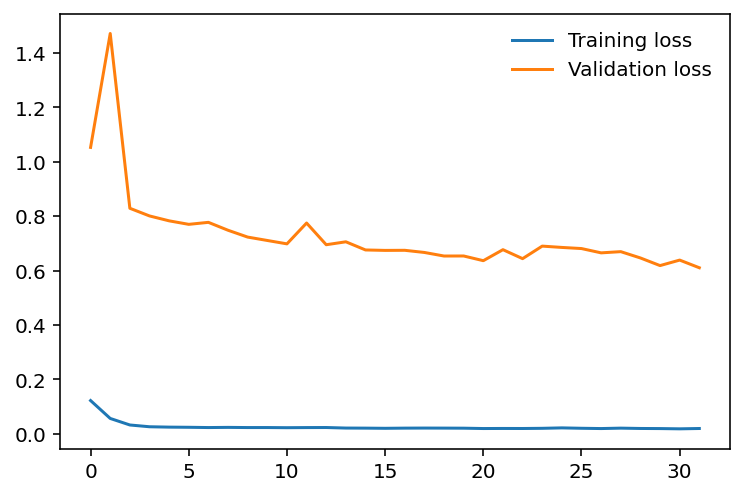

In [18]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [19]:
torch.save(model, '/home/tsb7592/Downloads/newmodel4.pth')

# Validation

In [20]:
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model1=torch.load('aerialmodel.pth')
model.eval()

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index


def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [29]:
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),])

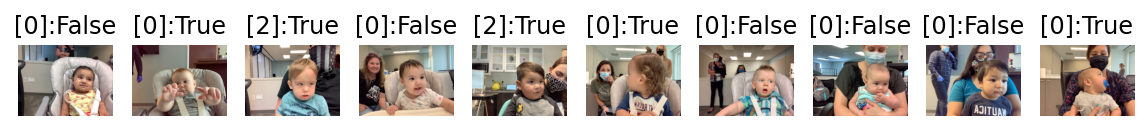

In [22]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(10)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str([index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()